# Read Data

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision.datasets import ImageFolder
from datetime import datetime
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
import torchvision.transforms as tt
from torch.utils.data import random_split

In [ ]:
! pip install -q kaggle
from google.colab import files

files.upload()
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! mkdir Dataset

Saving kaggle.json to kaggle (2).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
mkdir: cannot create directory ‘Dataset’: File exists


In [ ]:
!kaggle datasets download -d puneet6060/intel-image-classification

intel-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip intel-image-classification  -d  Dataset  

Archive:  intel-image-classification.zip
replace Dataset/seg_pred/seg_pred/10004.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
transform_ds = transforms.Compose([transforms.Resize((150,150)),
                                      transforms.ColorJitter(),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.
                                      transforms.Normalize([0.5, 0.5, 0.5],
                                                           [0.5, 0.5, 0.5])
                                      ])

transform_dt = transforms.Compose([transforms.Resize((150,150)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5, 0.5, 0.5],
                                                           [0.5, 0.5, 0.5]),
                                      
                                     
])

trainset = datasets.ImageFolder('Dataset/seg_train/seg_train',transform=transform_ds)
testset = datasets.ImageFolder('Dataset/seg_test/seg_test',transform=transform_dt)

In [ ]:
val_size = int(len(trainset) * 0.2)
train_size = len(trainset) - val_size

trainset, valset = random_split(trainset, [train_size, val_size])
len(trainset), len(valset)

(11228, 2806)

In [ ]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size= 128, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = torch.utils.data.DataLoader(valset, batch_size= 128*2, shuffle=False, num_workers=2, pin_memory=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size= 128*2, shuffle=False, num_workers=2, pin_memory=True)

classes = ('buildings', 'forest', 'glacier', 'mountain', 'sea', 'street')

# Visualization

In [ ]:
stats = ((0.4951, 0.4982, 0.4979), (0.2482, 0.2467, 0.2807))
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

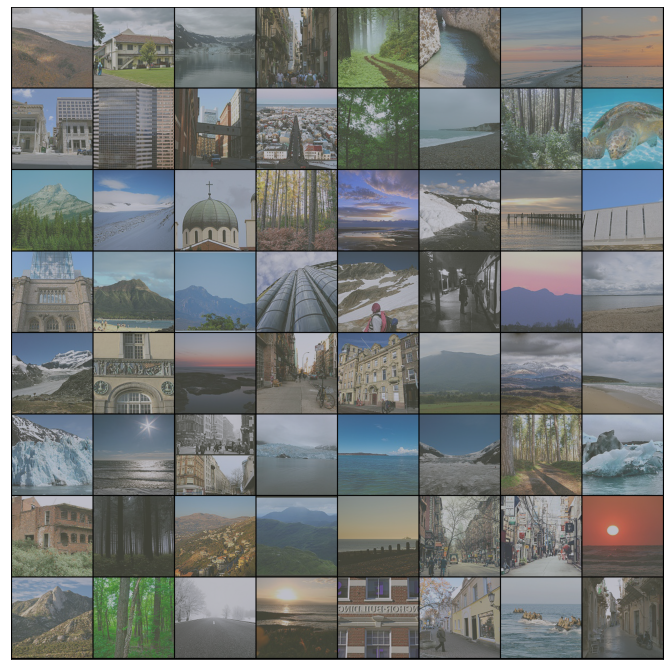

In [ ]:
show_batch(train_loader)

In [ ]:
a = next(iter(train_loader))
image,labels = a

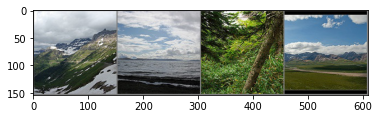

glacier , sea , forest , mountain


In [ ]:
img = torchvision.utils.make_grid(image[:4]) / 2 + 0.5     # unnormalize
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()
print(f'{classes[labels[:4][0]]} , {classes[labels[:4][1]]} , {classes[labels[:4][2]]} , {classes[labels[:4][3]]}')

# Build Model

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs,temp):
      if temp == 'val':
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
      elif temp =='test':
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item()}        
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_loader = DeviceDataLoader(train_loader, device)
valid_loader = DeviceDataLoader(valid_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
model = to_device(ResNet9(3, 6), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader,temp):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs,temp)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


In [ ]:
history = [evaluate(model, valid_loader,'val')]
history

[{'val_loss': 1.7911897897720337, 'val_acc': 0.16292209923267365}]

In [ ]:
epochs = 18
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
torch.cuda.empty_cache()
temp_history = []

# Set up cutom optimizer with weight decay
optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
# Set up one-cycle learning rate scheduler
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                            steps_per_epoch=len(train_loader))

for epoch in range(epochs):
    # Training Phase 
    model.train()
    train_losses = []
    lrs = []
    for batch in train_loader:
        loss = model.training_step(batch)
        train_losses.append(loss)
        loss.backward()
        
        # Gradient clipping
        if grad_clip: 
            nn.utils.clip_grad_value_(model.parameters(), grad_clip)
        
        optimizer.step()
        optimizer.zero_grad()
        
        # Record & update learning rate
        lrs.append(get_lr(optimizer))
        sched.step()
    
    # Validation phase
    result = evaluate(model, valid_loader,'val')
    result['train_loss'] = torch.stack(train_losses).mean().item()
    result['lrs'] = lrs
    model.epoch_end(epoch, result)
    temp_history.append(result)

history += temp_history

Epoch [0], last_lr: 0.00000, train_loss: 1.2812, val_loss: 0.6813, val_acc: 0.7609
CPU times: user 1min 8s, sys: 1min 12s, total: 2min 21s
Wall time: 2min 24s


In [ ]:
train_loss_list = [history[i+1]['train_loss'] for i in range(len(history)-1)]
train_loss_list

[1.2812317609786987]

In [ ]:
val_loss_list = [history[i]['val_loss'] for i in range(len(history))]
val_loss_list

[1.7911897897720337, 0.6813441514968872]

In [ ]:
accuracy_list = [history[i]['val_acc'] for i in range(len(history))]
accuracy_list

[0.16292209923267365, 0.7609103918075562]

In [ ]:
iteration_list = [i for i in range(len(history))]

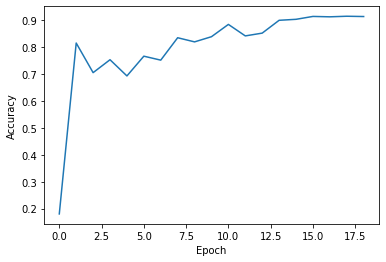

In [ ]:
plt.plot(iteration_list, accuracy_list)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

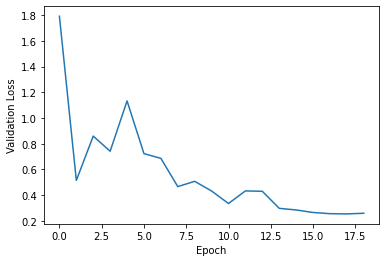

In [ ]:
plt.plot(iteration_list, val_loss_list)
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.show()

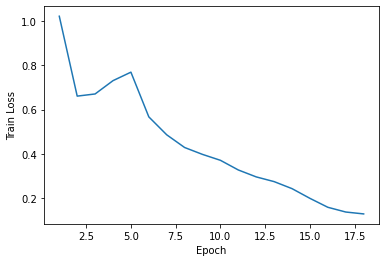

In [ ]:
plt.plot(iteration_list[1:], train_loss_list)
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.show()

In [ ]:
test_loader = DeviceDataLoader(test_loader, device)
result = evaluate(model, test_loader,'test')
result

{'test_loss': 0.6640315055847168, 'test_acc': 0.7560999989509583}